In [248]:
## IMPORTS

# BASE
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

# SKLEARN
from sklearn.model_selection import train_test_split
# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
## Hyperparameter Tuning
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, TimeSeriesSplit

from xgboost import XGBRegressor

In [249]:
## CHARTS

def plot_sales(dataframe, title, ylabel, xlabel, color='red'):
    
    plt.figure(figsize=(15, 3))
    plt.title(title)
    plt.ylabel(ylabel, color='white')
    # format y axis as currency
    # plt.gca().yaxis.set_major_formatter('R${:,.0f}'.format)

    plt.xlabel(xlabel, color='white')

    plt.bar(dataframe.index, dataframe['Total Sales'])
    # plot mean price in 2nd y axis
    plt.twinx()
    plt.ylabel('Mean Price', color='white')
    # plt.gca().yaxis.set_major_formatter('R${:,.0f}'.format)

    plt.plot(dataframe.index, dataframe['Mean Price'], color=color, linewidth=4)
    plt.show()

In [250]:
## MODELS

def fit_models(X_train, y_train, X_test, y_test):
    models = {'Linear Regression': LinearRegression(),
              'Decision Tree': DecisionTreeRegressor(),
              'Random Forest': RandomForestRegressor(),
              'Gradient Boosting': GradientBoostingRegressor()}

    models_df = pd.DataFrame(columns=['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
                             index=['R2', 'RMSE', 'MAE'])

    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        r2 = r2_score(y_test, pred)
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae = mean_absolute_error(y_test, pred)
        
        models_df[name] = [r2, rmse, mae]

    return models_df, models # returns df with models performance and models dict

In [251]:
## OPEN FILE

lots = pd.read_csv('../clean-files/catalogo_artworks_info.csv', index_col=0)
lots.drop(columns=['Error', '0', '0.1', '0.2', '0.3', '0.4'], inplace=True)

print('Lots count:', lots.shape[0])
print('Lots columns:', lots.columns)

Lots count: 12673
Lots columns: Index(['artist_link', 'Descrição', 'Fonte de Pesquisa', 'Data da Pesquisa',
       'Type', 'Século', 'Artist', 'Título', 'url', 'Década', 'img_url',
       'Medium', 'Height (cm)', 'Width (cm)', 'Area (cm²)', 'Price (BRL)',
       'Price (USD)', 'Medium_type', 'Sold', 'Year of sale'],
      dtype='object')


In [252]:
## SELECT ARTISTS

catalogo_artists = [
    'José Pancetti - Giuseppe Gianinni Pancetti - Jose Pancetti',
    'Candido Portinari (1903-1962)',
    'Di Cavalcanti (1897-1976)',
    'Alberto Guignard - Alberto da Veiga Guignard',
    'Antônio Bandeira (1922-1967)',
    'Ismael Nery',
    'Tarsila do Amaral',
    'Maria Martins',
    'Maria Leontina Franco Da Costa',
    'Djanira da Motta e Silva',
    'Ibere Camargo - Iberê Camargo',
    'Milton Dacosta',
    'Cildo Meireles (1948)',
    'Helio Oiticica - Hélio Oiticica',
    'Annita Catarina Malfatti - Anita Malfatti - Anita Malfati',
]

lots = lots[lots['Artist'].isin(catalogo_artists)]

In [253]:
# SOLD LOTS
sold_lots = lots[lots['Sold'] == True]
print('Sold lots: ', len(sold_lots))

Sold lots:  5542


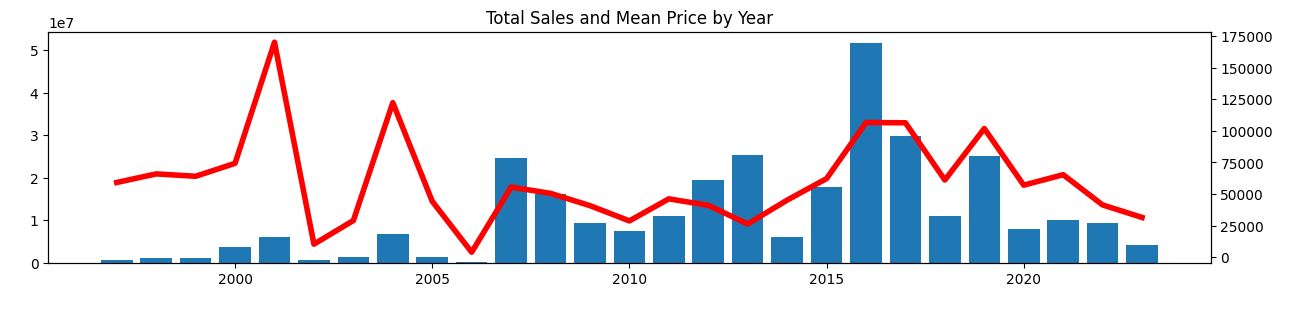

In [254]:
# PLOT TOTAL SALES AND MEAN PRICE BY YEAR
sales = pd.DataFrame(sold_lots.groupby('Year of sale')['Price (BRL)'].sum())
sales['Total Sales'] = sold_lots.groupby('Year of sale')['Price (BRL)'].sum()
sales['Mean Price'] = sold_lots.groupby('Year of sale')['Price (BRL)'].mean()

plot_sales(sales, 'Total Sales and Mean Price by Year', 'Total Sales', 'Year')

In [255]:
# TOP ARTISTS BY SALES COUNT

# dataframe with 2 columns: #sales, total sales ($) and mean price ($)
top_artists = pd.DataFrame(sold_lots['Artist'].value_counts())
top_artists['Total Sales'] = sold_lots.groupby('Artist')['Price (BRL)'].sum()
top_artists['Mean Price'] = sold_lots.groupby('Artist')['Price (BRL)'].mean()
# include mean area
top_artists['Mean Area'] = sold_lots.groupby('Artist')['Area (cm²)'].mean()
# mean price per area
top_artists['Mean Price per Area'] = top_artists['Mean Price'] / top_artists['Mean Area']

top_artists = top_artists.sort_values(by='Total Sales', ascending=False)
top_artists.drop('Mean Area', axis=1, inplace=True)
top_artists.head()

,count,Total Sales,Mean Price,Mean Price per Area
Artist,,,,
Alberto Guignard - Alberto da Veiga Guignard,294,60778045.0,206728.044218,29.703807
Candido Portinari (1903-1962),750,56321402.0,75095.202667,58.706394
Antônio Bandeira (1922-1967),562,44234550.0,78709.163701,44.260454
José Pancetti - Giuseppe Gianinni Pancetti - Jose Pancetti,280,40294220.0,143907.928571,91.336134
Di Cavalcanti (1897-1976),566,26449055.0,46729.779152,20.711885


In [256]:
## ARTISTS DATAFRAMES

artists = sold_lots.groupby('Artist').apply(lambda x: x.sort_values('Price (BRL)', ascending=False)).reset_index(drop=True).groupby('Artist')

artists_dataframes = {}
for artist in artists:
    artist_name = artist[0]
    artist_df = artist[1]
    artists_dataframes[artist_name] = artist_df

Found 750 lots for Candido Portinari (1903-1962)


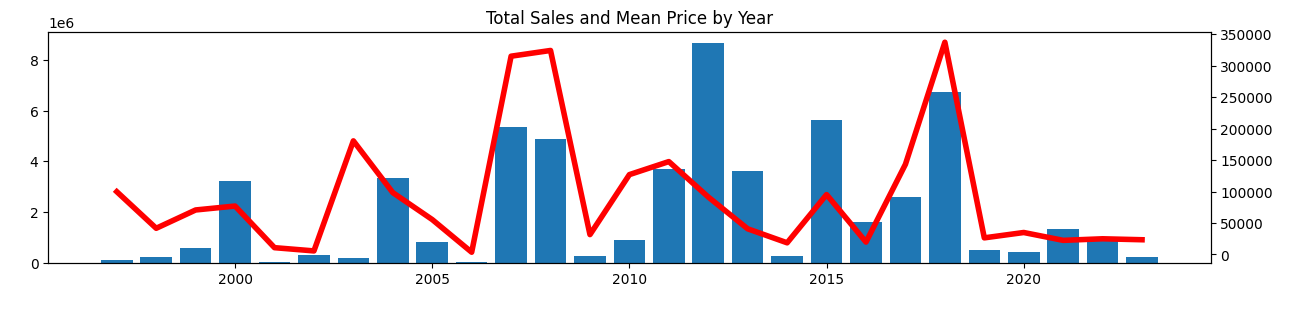

In [257]:
artist_name = 'Candido Portinari (1903-1962)'
artist_df = artists_dataframes[artist_name]

# PLOT TOTAL SALES AND MEAN PRICE BY YEAR
artist_sales = pd.DataFrame(artist_df.groupby('Year of sale')['Price (BRL)'].sum())
artist_sales['Total Sales'] = artist_df.groupby('Year of sale')['Price (BRL)'].sum()
artist_sales['Mean Price'] = artist_df.groupby('Year of sale')['Price (BRL)'].mean()

print(f'Found {artist_df.shape[0]} lots for {artist_name}')
plot_sales(artist_sales, 'Total Sales and Mean Price by Year', 'Total Sales', 'Year')

In [259]:
lots = lots[lots['Medium_type'] != 'outro'] ## ONLY PAINTING

lots['Price per Area'] = lots['Price (BRL)'] / lots['Area (cm²)']

print(len(lots))
# for each medium_type, remove outliers: lots with price / area > 0.9 percentile
for medium_type in lots['Medium_type'].unique():
    medium_type_lots = lots[lots['Medium_type'] == medium_type]
    medium_type_lots = medium_type_lots[medium_type_lots['Price per Area'] < medium_type_lots['Price per Area'].quantile(0.9)]
    print(medium_type, len(medium_type_lots))
    lots = pd.concat([lots[lots['Medium_type'] != medium_type], medium_type_lots])

print(len(lots))

11340
desenho 2586
reprodução 2267
pintura 5275
10128


In [260]:
## MODELS

def fit_models(X_train, y_train, X_test, y_test):
    models = {'Linear Regression': LinearRegression(),
              'Decision Tree': DecisionTreeRegressor(),
              'Random Forest': RandomForestRegressor(),
              'Gradient Boosting': GradientBoostingRegressor()}

    models_df = pd.DataFrame(columns=['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
                             index=['RMSE', 'MAE'])

    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae = mean_absolute_error(y_test, pred)
        
        models_df[name] = [rmse, mae]

    return models_df, models # returns df with models performance and models dict

In [261]:
## FILL MISSING VALUES IN 'Year' COLUMN

# # print count of lots that dont have a value for 'Year
# year_missing = lots[lots['Ano'].isna()]
# print('Lots without year:', year_missing.shape[0])
# # lots without year but with década
# print('Lots with século:', year_missing[year_missing['Década'].notna()].shape[0])

In [262]:
## FIT PRICE MODELS

# hide all warnings
import warnings
warnings.filterwarnings('ignore')

lots_to_model = lots[['Artist', 'Width (cm)', 'Height (cm)', 'Year of sale', 'Price (BRL)', 'Medium_type']]#, 'Year']]
lots_to_model.dropna(subset=['Artist', 'Width (cm)', 'Height (cm)', 'Year of sale', 'Price (BRL)', 'Medium_type'], inplace=True)
# lots_to_model.fillna(value=1970, inplace=True) # fill NaN year with 1970

print('shape of lots_to_model (before split):', str(lots_to_model.shape))

X = lots_to_model.drop(['Price (BRL)'], axis=1)
y = lots_to_model['Price (BRL)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train = pd.get_dummies(X_train, columns=['Artist', 'Medium_type'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Artist', 'Medium_type'], drop_first=True)

print('model features:', len(X_train.columns))

# add to X_test all columns that are in X_train but not in X_test
for column in X_train.columns:
    if column not in X_test.columns:
        X_test[column] = 0

# remove from x_test all columns that are in X_test but not in X_train
for column in X_test.columns:
    if column not in X_train.columns:
        X_test.drop(column, axis=1, inplace=True)

# sort columns alphabetically
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
X_test = X_test.reindex(sorted(X_test.columns), axis=1)

models_df, models = fit_models(X_train, y_train, X_test, y_test)

models_df

shape of lots_to_model (before split): (10128, 6)
model features: 19


,Linear Regression,Decision Tree,Random Forest,Gradient Boosting
RMSE,91386.621453,57090.945052,42494.309559,59396.920399
MAE,52247.544214,10644.980427,9857.853424,24612.539796


In [263]:
## RANDOM FOREST RANDOM SEARCH

space={'max_depth':list(np.arange(10, 100, step=30)) + [None],
              'n_estimators':np.arange(10, 210, step=50),
              'min_samples_leaf':randint(1, 10),
              'min_samples_split':np.arange(1, 10, step=1)
         }

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(rf, space, n_iter=100, scoring='neg_mean_squared_error', n_jobs=-1, cv=3)
model_random = rf_random.fit(X_train, y_train)

print('Best hyperparameters are: '+str(model_random.best_params_))
print('Best score is: '+str(model_random.best_score_))

rf_model = RandomForestRegressor(space)
rf_model.fit(X_train, y_train)
pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
print('MSE:', mse)
print('MAE:', mae)

Best hyperparameters are: {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 60}
Best score is: -3628745165.460716


InvalidParameterError: The 'n_estimators' parameter of RandomForestRegressor must be an int in the range [1, inf). Got {'max_depth': [10, 40, 70, None], 'n_estimators': array([ 10,  60, 110, 160]), 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x133c0f2d0>, 'min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9])} instead.

In [ ]:
## XGBOOST RANDOM SEARCH

# Define a wider range for learning_rate and additional hyperparameters
xgb_params = {
    'learning_rate': [0.2, 0.3, 0.35, 0.4, 0.45, 0.5],
    'max_depth': [7, 8, 9, 10, 11, 12],
    'min_child_weight': [1, 2, 3, 4, 5, 6],
}

# Perform RandomizedSearchCV for XGBoost with additional hyperparameters
xgb = XGBRegressor()
tscv = TimeSeriesSplit(n_splits=3)  # Use TimeSeriesSplit for better handling of time-series data
xgb_random = RandomizedSearchCV(xgb, param_distributions=xgb_params, n_iter=100, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
model_xgb = xgb_random.fit(X_train, y_train)

# Print best parameters
print('Best parameters found: ', model_xgb.best_params_)

previous_mse_xgb = mse_xgb
previous_mae_xgb = mae_xgb

# Evaluate XGBoost model
pred_xgb = model_xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, pred_xgb)
mae_xgb = mean_absolute_error(y_test, pred_xgb)
print('XGBoost MSE:', mse_xgb)
print('XGBoost MAE:', mae_xgb)

# compare with the previous model
print()
print('MSE improvement:', previous_mse_xgb - mse_xgb)
print('MAE improvement:', previous_mae_xgb - mae_xgb)


Best parameters found:  {'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.4}
XGBoost MSE: 1928786886.3779917
XGBoost MAE: 8882.151764376442

MSE improvement: 254253547.94161987
MAE improvement: 472.32080406487876


In [ ]:
pred_rf = models['Random Forest'].predict(X_test)
pred_dt = models['Decision Tree'].predict(X_test)

weight_rf = 0
weight_dt = 0
ensemble_df = pd.DataFrame(columns=['MSE', 'MAE', 'Weight XGB', 'Weight RF', 'Weight DT'])
for i in range(0,10):
    weight_xgb = 1 - weight_rf - weight_dt
    
    final_pred = (weight_xgb * pred_xgb) + (weight_rf * pred_rf) + (weight_dt * pred_dt)
    
    ensemble_mse = mean_squared_error(y_test, final_pred)
    ensemble_mae = mean_absolute_error(y_test, final_pred)

    # store mse, mae and weights in a dataframe 
    ensemble_df.loc[i] = [f'{ensemble_mse:.2f}', ensemble_mae, weight_xgb, weight_rf, weight_dt]

    weight_rf += 0.1
    weight_dt += 0.1
    

ensemble_df.sort_values(by='MSE')

,MSE,MAE,Weight XGB,Weight RF,Weight DT
3,1709379878.20,8792.175960,0.4,0.3,0.3
4,1710595634.65,8871.193049,0.2,0.4,0.4
2,1745339809.02,8778.281095,0.6,0.2,0.2
5,1748987105.25,9076.105420,0.0,0.5,0.5
1,1818475507.73,8807.371734,0.8,0.1,0.1
6,1824554289.99,9417.164133,-0.2,0.6,0.6
0,1928786886.38,8882.151764,1.0,0.0,0.0
7,1937297188.87,9901.569238,-0.4,0.7,0.7
8,2087215841.08,10476.275379,-0.6,0.8,0.8
9,2274310129.08,11107.922414,-0.8,0.9,0.9


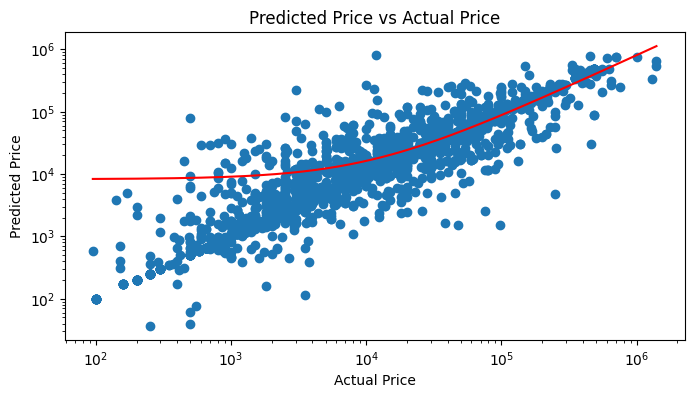

In [ ]:
## COMPARE MODEL PERFORMANCE ACROSS MEDIUM TYPES
# add predicted_price column to lots_to_model
lots_copy = X_test.copy()
lots_copy['Predicted Price'] = final_pred
lots_copy['Actual Price'] = y_test
lots_copy['Error'] = lots_copy['Predicted Price'] - lots_copy['Actual Price']
lots_copy['Error %'] = lots_copy['Error'] / lots_copy['Actual Price'] - 1

# scatter plot: predicted price vs actual price
plt.figure(figsize=(8,4))
plt.title('Predicted Price vs Actual Price')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
# format axes: separate thousands with comma and format as currency
plt.gca().xaxis.set_major_formatter('${x:,.0f}')
plt.gca().yaxis.set_major_formatter('${x:,.0f}')
plt.xscale('log')
plt.yscale('log')
plt.scatter(lots_copy['Actual Price'], lots_copy['Predicted Price'])
# include trend line
plt.plot(np.unique(lots_copy['Actual Price']), np.poly1d(np.polyfit(lots_copy['Actual Price'], lots_copy['Predicted Price'], 1))(np.unique(lots_copy['Actual Price'])), color='red')
plt.show()

In [ ]:
lots_to_model['Medium_type'].value_counts()

Medium_type
pintura       4003
desenho       2268
reprodução    2095
outro          733
Name: count, dtype: int64

In [ ]:
lots_copy.columns

Index(['Artist_Annita Catarina Malfatti - Anita Malfatti - Anita Malfati',
       'Artist_Antônio Bandeira (1922-1967)',
       'Artist_Candido Portinari (1903-1962)', 'Artist_Cildo Meireles (1948)',
       'Artist_Di Cavalcanti (1897-1976)', 'Artist_Djanira da Motta e Silva',
       'Artist_Helio Oiticica - Hélio Oiticica',
       'Artist_Ibere Camargo - Iberê Camargo', 'Artist_Ismael Nery',
       'Artist_José Pancetti - Giuseppe Gianinni Pancetti - Jose Pancetti',
       'Artist_Maria Leontina Franco Da Costa', 'Artist_Maria Martins',
       'Artist_Milton Dacosta', 'Artist_Tarsila do Amaral', 'Height (cm)',
       'Medium_type_pintura', 'Medium_type_reprodução', 'Width (cm)',
       'Year of sale', 'Predicted Price', 'Actual Price', 'Error', 'Error %'],
      dtype='object')

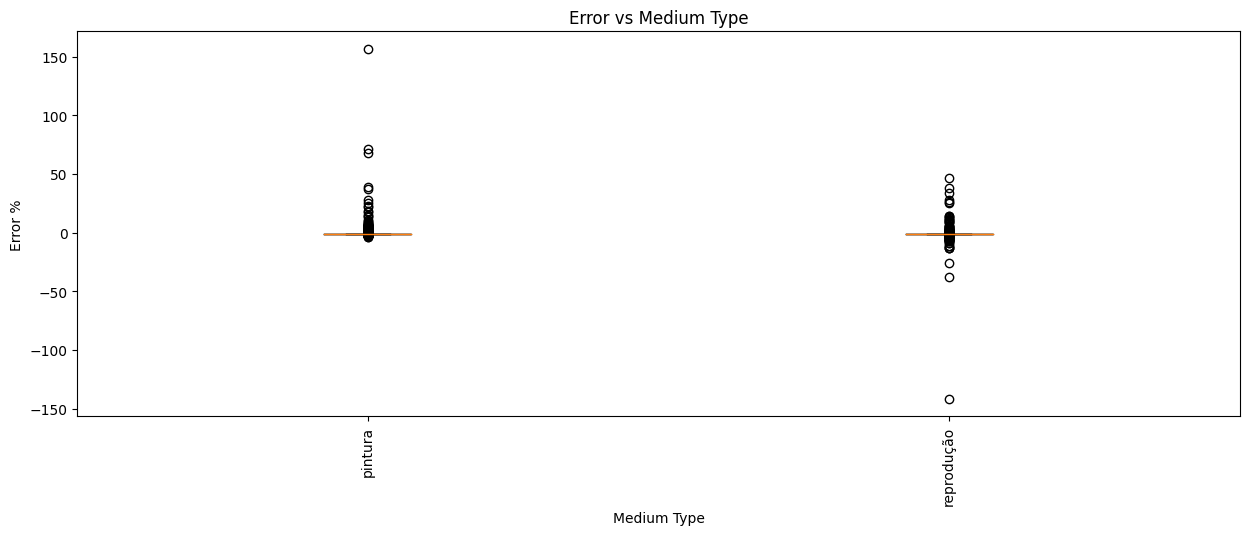

In [266]:
## COMPARE PCT ERROR ACROSS MEDIUM TYPES

medium_types = ['pintura', 'reprodução'] #, 'desenho']

## Compare pct error across medium types
# boxplot: error vs medium type
plt.figure(figsize=(15, 5))
plt.title('Error vs Medium Type')
plt.xlabel('Medium Type')
plt.ylabel('Error %')
plt.xticks(rotation=90)
plt.boxplot([
             lots_copy[lots_copy['Medium_type_pintura'] == 1]['Error %'],
             #lots_copy[lots_copy['Medium_type_desenho'] == 1]['Error %'],
             lots_copy[lots_copy['Medium_type_reprodução'] == 1]['Error %']],
             labels=medium_types)
plt.show()

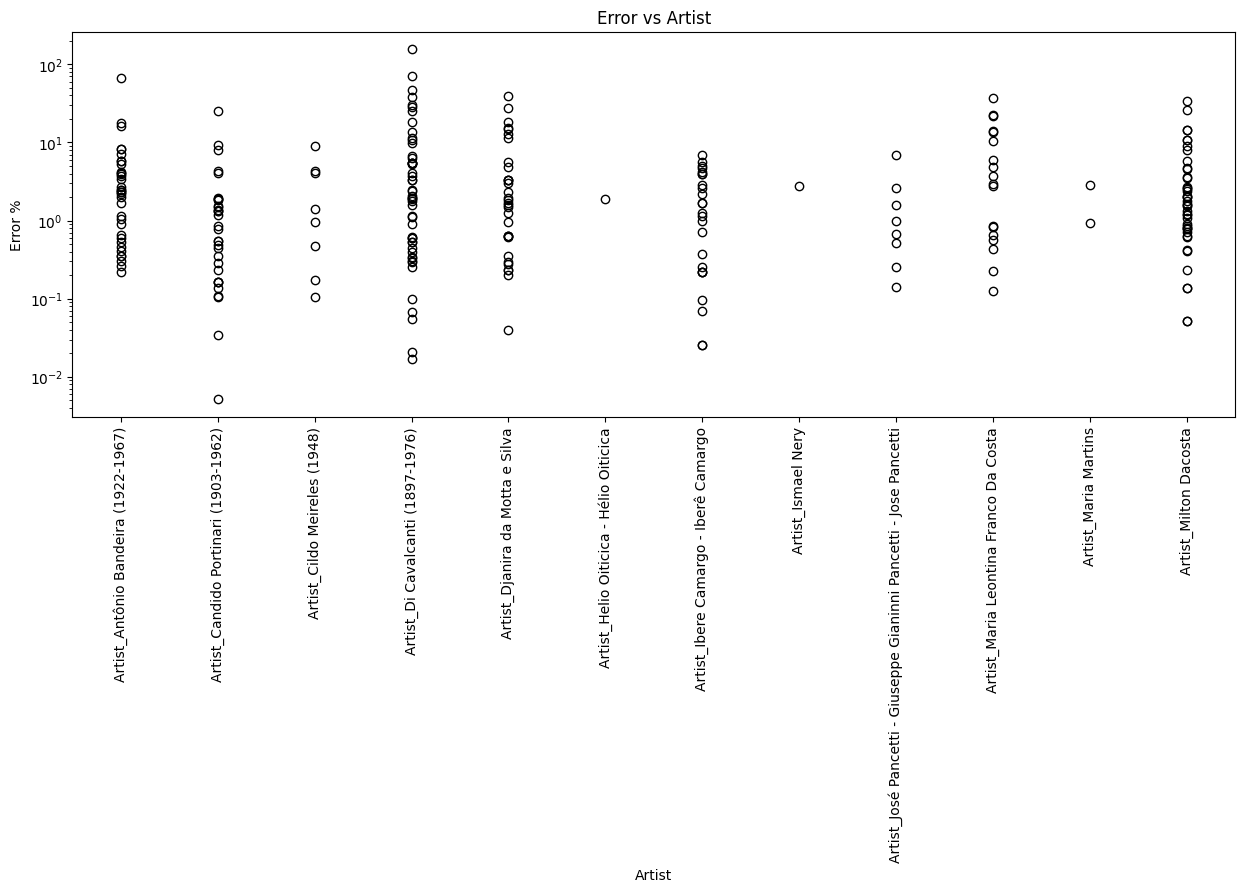

In [265]:
## COMPARE PCT ERROR ACROSS ARTISTS
artists = lots_copy.columns[1:-10]

# boxplot: error vs artist
plt.figure(figsize=(15, 5))
plt.title('Error vs Artist')
plt.xlabel('Artist')
plt.ylabel('Error %')
plt.yscale('log')
plt.xticks(rotation=90)
plt.boxplot([lots_copy[lots_copy[artist] == 1]['Error %'] for artist in artists], labels=artists)
plt.show()

In [ ]:
# show 10 biggest errors
lots_copy.sort_values('Error %', ascending=False).head(10)

,Artist_Annita Catarina Malfatti - Anita Malfatti - Anita Malfati,Artist_Antônio Bandeira (1922-1967),Artist_Candido Portinari (1903-1962),Artist_Cildo Meireles (1948),Artist_Di Cavalcanti (1897-1976),Artist_Djanira da Motta e Silva,Artist_Helio Oiticica - Hélio Oiticica,Artist_Ibere Camargo - Iberê Camargo,Artist_Ismael Nery,Artist_José Pancetti - Giuseppe Gianinni Pancetti - Jose Pancetti,...,Height (cm),Medium_type_outro,Medium_type_pintura,Medium_type_reprodução,Width (cm),Year of sale,Predicted Price,Actual Price,Error,Error %
Year,,,,,,,,,,,,,,,,,,,,,
NaN,False,False,False,False,True,False,False,False,False,False,...,92.0,False,False,True,64.0,2013,53775.0,20.0,53755.0,2686.750000
1952.0,False,False,False,False,False,False,False,False,False,True,...,55.0,True,False,False,38.0,2018,21820.0,100.0,21720.0,216.200000
1952.0,False,False,False,False,False,False,False,False,False,True,...,55.0,True,False,False,38.0,2018,21820.0,100.0,21720.0,216.200000
1950.0,False,False,False,False,True,False,False,False,False,False,...,60.0,False,True,False,72.0,2019,262000.0,1420.0,260580.0,182.507042
NaN,False,False,False,False,False,False,False,False,False,True,...,65.0,True,False,False,46.0,2018,17750.0,100.0,17650.0,175.500000
1973.0,False,False,False,False,True,False,False,False,False,False,...,45.0,False,True,False,55.0,2013,85675.0,500.0,85175.0,169.350000
NaN,False,False,False,False,False,False,False,False,False,False,...,65.0,False,True,False,50.0,2013,67895.0,400.0,67495.0,167.737500
NaN,False,False,False,False,True,False,False,False,False,False,...,95.0,False,True,False,64.0,2017,421975.0,3000.0,418975.0,138.658333
NaN,False,False,False,False,False,False,False,True,False,False,...,123.0,False,False,True,93.0,2022,269535.0,3600.0,265935.0,72.870833


In [264]:
## SAVE LOCALLY MODEL AND X_TEST

# save model to models folder
model = model_xgb
with open('./models/catalogo_xgb_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# save X_test as csv
X_test.to_csv('./models/catalogo_X_test.csv', index=False)